# Transfer Learning with Tensorflow part 2: Fine Tuning

In the previous notebook, we covered transfer learning feature extraction. Now it's time to learn a new kind of tranfer learning: fine-tuning.

In [2]:
import tensorflow as tf
!nvidia-smi
tf.config.list_physical_devices
import tensorflow as tf
print(tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
!python --version

2024-09-13 15:36:33.311582: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-13 15:36:33.838282: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-13 15:36:34.133191: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-13 15:36:34.365775: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Fri Sep 13 15:36:45 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.31.02              Driver Version: 560.31.02      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
Killed
2.17.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Python 3.11.0rc1


I0000 00:00:1726241818.549821      28 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726241819.042811      28 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726241819.045557      28 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


## Creating helper function
In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

Always a good idea to use helper functions remember the don't repeat yourself rule

In [5]:
!apt-get install wget
!pip install scikit-learn
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
wget is already the newest version (1.21.2-2ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 114.3 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 6.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 359.1 kB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 2.6 MB/s eta 0:00:00:00:0100:01

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
--2024-09-13 15:47:25--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercont

In [6]:
# Import helper functions we're going to use in the notebook
from helper_functions import *


> **Note** if you're running this notebook in Colab, the runtime may time out.  When the runtime runs out colab will delete the helper function so will need to redownload.

## Let's get some data

This time we're going to see how we can use the pre-trained models within tf.keras.applications and apply them to our own problem(recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications


In [7]:
# Get 10% of training data of 10 classes of Food101
if(not os.path.exists("10_food_classes_10_percent.zip")):
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
    unzip_data("10_food_classes_10_percent.zip")

In [8]:
# Checkout how many images and sub directories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

In [9]:
# Create training and test directory path
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [10]:
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size = BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                          image_size=IMG_SIZE,
                                                                          label_mode="categorical",
                                                                          batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.


I0000 00:00:1726242448.309413      28 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726242448.312427      28 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726242448.314348      28 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726242448.466551      28 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Found 2500 files belonging to 10 classes.


In [11]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [12]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [13]:
# See an example of batch of data
for images,labels in train_data_10_percent.take(1):
    print(images,labels)

tf.Tensor(
[[[[4.03979607e+01 3.83979607e+01 2.63979588e+01]
   [3.82091827e+01 3.52091827e+01 2.63520412e+01]
   [1.34438801e+01 1.20153084e+01 6.58673620e+00]
   ...
   [4.07655144e+00 9.29084587e+00 1.16479626e+01]
   [5.33162165e+00 1.13316212e+01 1.13316212e+01]
   [9.43889081e-01 4.48470879e+00 5.48470879e+00]]

  [[3.23316345e+01 2.99999981e+01 1.89948978e+01]
   [3.34132652e+01 3.04132652e+01 2.34132652e+01]
   [1.73418388e+01 1.59132671e+01 1.16122475e+01]
   ...
   [2.99999046e+00 7.21428490e+00 1.02142849e+01]
   [2.14795732e+00 7.14795732e+00 1.01479568e+01]
   [2.55104303e-02 3.73980474e+00 6.73980474e+00]]

  [[2.23520412e+01 1.93520412e+01 1.27806129e+01]
   [3.54744911e+01 3.24030609e+01 2.75459175e+01]
   [2.35510235e+01 2.19081650e+01 1.96938801e+01]
   ...
   [4.50507975e+00 5.93366861e+00 1.01479626e+01]
   [2.03060484e+00 6.48981571e+00 1.11581774e+01]
   [2.42856693e+00 7.21428108e+00 1.38571386e+01]]

  ...

  [[3.63571854e+01 2.31429234e+01 1.49286585e+01]
   [4

2024-09-13 15:47:31.814787: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Model 0: building a transfer learning model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility in desiging our models

In [14]:
# Create base model
efficentnet_b0 = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    classes=10,
    classifier_activation='softmax',
)

efficentnet_b0.trainable = False

# create inputs for model
inputs = tf.keras.layers.Input(shape=(224,224,3),name="input_layer")
# normalize, needed for some architectures
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = efficentnet_b0(inputs)
print(f"Shape after passing inputs through the base model:{x.shape}")
# average pool the outputs of base model(aggregate most important information, reduce computational expenses)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D:{x.shape}")
# create output activation layer
outputs = tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)
# combine inputs and outputs into model
model_0 = tf.keras.Model(inputs,
                   outputs)

model_0.compile(optimizer=tf.keras.optimizers.Adam(),
                       loss=tf.keras.losses.CategoricalCrossentropy(),
                       metrics=["accuracy"])
history_model_0 = model_0.fit(train_data_10_percent,epochs=5,validation_data=test_data,validation_steps=int(0.25*len(test_data)),callbacks=[create_tensorboard_callback(dir_name="transfer learning",experiment_name="10_percent_feature_extraction")])

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Shape after passing inputs through the base model:(None, 7, 7, 1280)
Shape after GlobalAveragePooling2D:(None, 1280)
Saving TensorBoard log files to: transfer learning/10_percent_feature_extraction/20240913-154734
Epoch 1/5


I0000 00:00:1726242461.681031     308 service.cc:146] XLA service 0x7c50bc002580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726242461.681125     308 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2024-09-13 15:47:42.315961: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-13 15:47:43.692964: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906
2024-09-13 15:47:45.525651: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11481', 20 bytes spill stores, 20 bytes spill loads

2024-09-13 15:47:45.602168: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in

23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3567 - loss: 1.9939

2024-09-13 15:48:17.989214: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11481', 12 bytes spill stores, 12 bytes spill loads



24/24 ━━━━━━━━━━━━━━━━━━━━ 55s 654ms/step - accuracy: 0.3650 - loss: 1.9776 - val_accuracy: 0.7533 - val_loss: 1.2566
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7465 - loss: 1.1509 - val_accuracy: 0.8174 - val_loss: 0.8546
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8402 - loss: 0.8081 - val_accuracy: 0.8405 - val_loss: 0.7024
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8544 - loss: 0.6463 - val_accuracy: 0.8372 - val_loss: 0.6228
Epoch 5/5
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8592 - loss: 0.5770

2024-09-13 15:48:33.215165: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2310', 16 bytes spill stores, 16 bytes spill loads



24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 0.8609 - loss: 0.5761 - val_accuracy: 0.8971 - val_loss: 0.5648


2024-09-13 15:48:36.244159: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-13 15:48:36.244205: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18328656882620295526
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [15]:
model_0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8567 - loss: 0.5626


[0.5590020418167114, 0.8543999791145325]

In [16]:
# check the layers in our base model
for layer_number, layer in enumerate(efficentnet_b0.layers):
    print(f"Layer number:{layer_number} layer name:{layer.name}") 

Layer number:0 layer name:input_layer
Layer number:1 layer name:rescaling
Layer number:2 layer name:normalization
Layer number:3 layer name:stem_conv
Layer number:4 layer name:stem_bn
Layer number:5 layer name:stem_activation
Layer number:6 layer name:block1a_project_conv
Layer number:7 layer name:block1a_project_bn
Layer number:8 layer name:block1a_project_activation
Layer number:9 layer name:block2a_expand_conv
Layer number:10 layer name:block2a_expand_bn
Layer number:11 layer name:block2a_expand_activation
Layer number:12 layer name:block2a_project_conv
Layer number:13 layer name:block2a_project_bn
Layer number:14 layer name:block2b_expand_conv
Layer number:15 layer name:block2b_expand_bn
Layer number:16 layer name:block2b_expand_activation
Layer number:17 layer name:block2b_project_conv
Layer number:18 layer name:block2b_project_bn
Layer number:19 layer name:block2b_drop
Layer number:20 layer name:block2b_add
Layer number:21 layer name:block3a_expand_conv
Layer number:22 layer name

In [17]:
# summary of base model
efficentnet_b0.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer[0][0] │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, None,      │          0 │ rescaling[0][0]   │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ normalization[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      4,608 │ stem_activation[… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │      9,216 │ block1a_project_… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, None,      │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, None,      │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, None,      │     36,864 │ block2a_project_… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, None,      │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, None,      │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

In [18]:
model_0.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

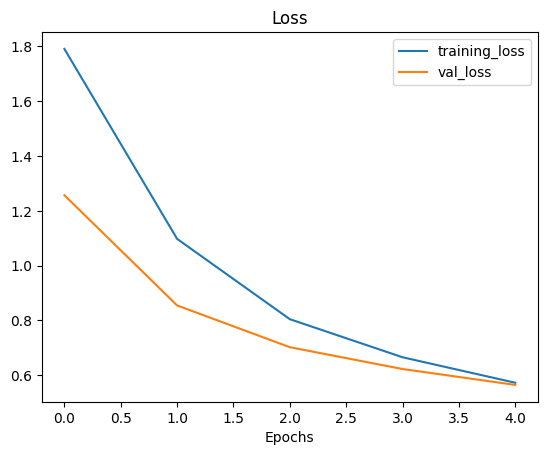

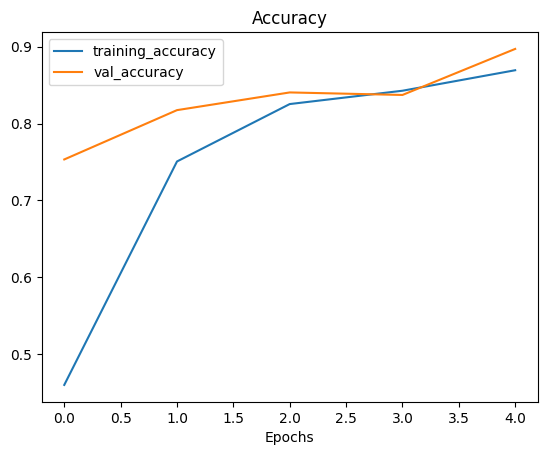

In [19]:
# Check out models training curves
plot_loss_curves(history_model_0)

## Getting a feature vector from a trained model 
Let's demonstrate the Global Average Pooling 2d layer...
We have a tensor after our model goes through `base+model` of shape (None,7,7,1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None,1280)

Let's use a similar shaped tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D

In [20]:
# define input shape
input_shape =(1,4,4,3)
#create a random tensor
tf.random.set_seed(42)
input_tensor=tf.random.normal(input_shape)
print(f"Random input tensor:\n{input_tensor}\n")

# Pass the random tensor through a random global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n{global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of global average pooled 2D: {global_average_pooled_tensor}")

Random input tensor:
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
[[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of global average pooled 2D: [[-0.09368646 -0.45840448 -0.2885598 ]]


In [21]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

**Practice** Try to do the same with the above two cells but this time use `GlobalMaxPool2D`... and see what happens

**Note** Onen of the reasons feature extraction transfer learning is named how it is is because what often happens is a pretrained model outputs a feature vector - a learned representation of the input data.

In [22]:
global_max_pool_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor) 
print(global_max_pool_tensor)

tf.Tensor([[0.9058464 1.1603122 1.6994323]], shape=(1, 3), dtype=float32)


## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with only 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning iwth 1% of the training data with augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation
3. `model_3` - use fine-tuning transfer learning with 10% of the training data which will also use data augmentation
4. `model_4`- use fine-tuning transfer learning on 100% of the training data with data augmentation.
   
**Note**: throughout all experiments we will use the same test dataset, so that we can be consistent in evaluation

## Getting and preprocessing data for model 1

In [23]:
# Download and unzip data
 
if not os.path.exists("./10_food_classes_1_percent.zip"):
    !wget "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip"
    unzip_data("10_food_classes_1_percent.zip")

In [24]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [25]:
# How many images are we working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There a

In [26]:
# Setup data loaders
IMG_SIZE = (224,224)

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                          label_mode="categorical",
                                                                          image_size=IMG_SIZE,
                                                                          batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


# Adding data augmentation right into the model


To add data augmentation right into our models, we can use the layers inside:

+ `tf.keras.layers.experimental.preprocessing()`

Benefits of data augmentation

+ More data - model may be better able to generalize
+ preprocessing of images(augmenting them) happens on the GPU which is far faster for this type of problem than the CPU
+ Image data augmentation only happens during training so we can still export out model and use it elsewhere.

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Create data augmentation stage with horizontal flipping, rotations, zooms,etc.
    
data_augmentation = keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    # tf.keras.layers.Rescaling(1./255) - keep for models like resnet50V2 but for efficientnet it has rescaling built in
],name="data_augmentation")

### visualize our data augmentation layer(and check the data)

10_food_classes_1_percent/train/steak
[[[ 2  7  3]
  [ 0  4  0]
  [ 0  3  0]
  ...
  [12 13  5]
  [13 14  6]
  [15 16  8]]

 [[ 2  7  3]
  [ 0  4  0]
  [ 0  4  0]
  ...
  [12 13  5]
  [12 13  5]
  [11 12  4]]

 [[ 1  6  2]
  [ 0  5  1]
  [ 0  4  0]
  ...
  [16 17  9]
  [13 14  6]
  [10 11  3]]

 ...

 [[ 5  5  3]
  [ 5  5  3]
  [ 6  6  6]
  ...
  [ 5  5  7]
  [ 5  5  7]
  [ 5  5  7]]

 [[ 5  6  1]
  [ 5  6  1]
  [ 5  5  3]
  ...
  [ 5  5  7]
  [ 5  5  7]
  [ 5  5  7]]

 [[ 5  6  1]
  [ 4  5  0]
  [ 4  4  2]
  ...
  [ 6  6  8]
  [ 6  6  8]
  [ 6  6  8]]]
3653129.jpg


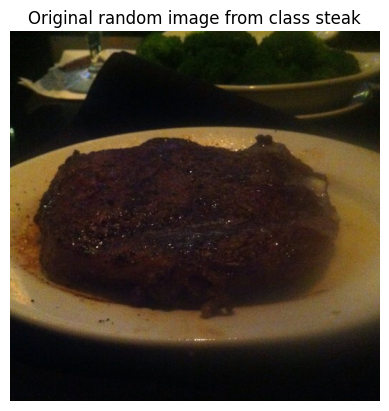

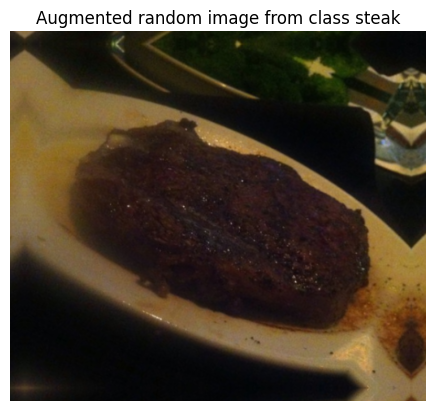

In [50]:
# View a random image and compare it to the augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
print(target_dir)
# read in random image + plot
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)
# now let's plot augmented random image
augmented_image = data_augmentation(img)
plt.figure()
plt.title(f"Augmented random image from class {target_class}")
plt.axis(False)
plt.imshow(tf.squeeze(augmented_image / 255.))
print(img)
print(random_image)

In [ ]:
target_data_1_percent.class_names

## Model 1: Feature extraction on transfer learning on 1% of the data using data augmentation